# DM 2026 Lab Assignment 2

## Data loading & Library Importing

In [36]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

# Load the data
train_data = np.load('train_data_2026.npy')
test_data = np.load('test_data_2026.npy')
val_data = np.load('val_data_2026.npy')

# Familiarization questions

### What properties of the data do you think are important for your pipeline design?

For our pipeline two key features are really important and those are sparsity and the distribution of labels (label imbalance etc.)
In order to see if we have sparce or not suer matrix let's calculate the NaN values and put them into percent

In [37]:
def compute_sparsity(matrix):
    total = train_data.size
    observed = np.sum(~np.isnan(train_data))
    sparsity = 1 - observed / total
    return sparsity

sparsity = compute_sparsity(train_data)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9943


According to our analysis, the sparsity of the interaction matrix is 0.9943, meaning that approximately 99.4% of all possible user–user interactions are missing. Such extreme sparsity strongly motivates the use of matrix factorization methods. In order to find the patterns or the correlations that is hidden under the hood.

Now we will look at the labels. But first let's see the labels and to figure out what we're working on

In [38]:
def label_distribution(matrix):
    values = matrix[~np.isnan(matrix)]
    labels, counts = np.unique(values, return_counts=True)
    total = counts.sum()
    return {label: (count, count / total) for label, count in zip(labels, counts)}

dist = label_distribution(train_data)

for label, (count, pct) in dist.items():
    print(f"Label {label}: {count} ({pct:.2%})")

Label 0.0: 42964 (82.43%)
Label 1.0: 9158 (17.57%)


From the output, we observe that there are two distinct labels in the user–user interaction matrix:
- Label 0.0
- Label 1.0

These labels indicate the absence or presence of an interaction between users. While the labels remain binary, a clear imbalance is observed in the distribution. Among the non-missing entries, approximately 82.43% correspond to label 0.0, whereas only 17.57% correspond to label 1.0. This shows that the observed interaction values are unevenly distributed, with positive interactions occurring significantly less frequently than non-interactions. Such label imbalance is an important factor to consider, as it may bias the learned latent representations.

### What are some sources of sparsity in the data?

Usually in these types of data sparsity can occur on these sources:
- Combinatorial Explosion:
  - For [user x user] matrix assuming there's N users there's N^2 different interactions
  - In practice, however, each user interacts with only a small subset of other users, resulting in a very limited number of observed interactions compared to the total number of possible ones. This leads to extreme sparsity, as reflected by the high sparsity level (approximately 99.4%).
- Cold Start Users:
  - Some users have few or no recorded interactions, especially newly joined or inactive users.
  - Until such users engage in interactions, there is little to no information available about their behavior, which contributes further to the overall sparsity of the interaction matrix.

#### Combinatorial Explosion:
In order to clearly see Combinatorial Explosion let's look at the interactions between users

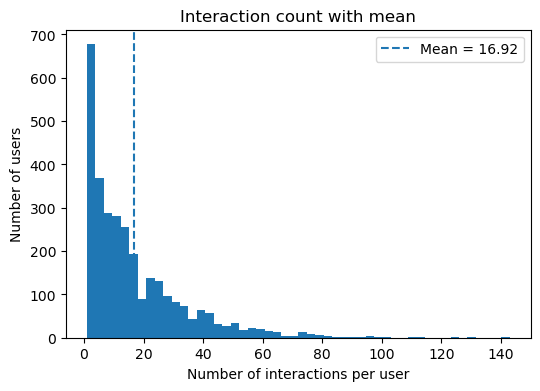

Users above mean: 1139 (36.97%)
Users below or equal mean: 1942 (63.03%)


In [39]:
interaction_count = np.sum(~np.isnan(train_data), axis=1)
mean_interactions = interaction_count.mean()

plt.figure(figsize=(6, 4))
plt.hist(interaction_count, bins=50)
plt.axvline(mean_interactions, linestyle='--', label=f"Mean = {mean_interactions:.2f}")
plt.xlabel("Number of interactions per user")
plt.ylabel("Number of users")
plt.title("Interaction count with mean")
plt.legend()
plt.show()

num_above = np.sum(interaction_count > mean_interactions)
num_below = len(interaction_count) - num_above

print(f"Users above mean: {num_above} ({num_above/len(interaction_count):.2%})")
print(f"Users below or equal mean: {num_below} ({num_below/len(interaction_count):.2%})")


As can be seen users below or equal mean is dominated thus this supports our conclusion on users mostly interacts not enough to fill the matrix

### Do you see different types of people?
In terms of different types of people we might categorize them as follow:
- Based on Activity:
  - How much likes/dislikes they have in total
  - is it Active
  - or is it Passive
- Based on Like ratio:
  - How much likes/dislikes they have given in total
  - is it Selective
  - or is it Not Selective

#### First let's focus on activity:

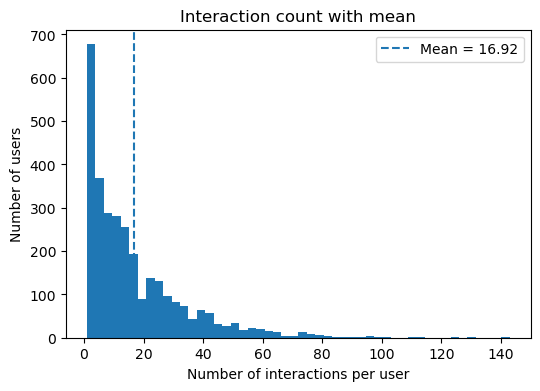

Users above mean: 1139 (36.97%)
Users below or equal mean: 1942 (63.03%)


In [40]:
interaction_count = np.sum(~np.isnan(train_data), axis=1)
mean_interactions = interaction_count.mean()

plt.figure(figsize=(6, 4))
plt.hist(interaction_count, bins=50)
plt.axvline(mean_interactions, linestyle='--', label=f"Mean = {mean_interactions:.2f}")
plt.xlabel("Number of interactions per user")
plt.ylabel("Number of users")
plt.title("Interaction count with mean")
plt.legend()
plt.show()

num_above = np.sum(interaction_count > mean_interactions)
num_below = len(interaction_count) - num_above

print(f"Users above mean: {num_above} ({num_above/len(interaction_count):.2%})")
print(f"Users below or equal mean: {num_below} ({num_below/len(interaction_count):.2%})")

Based on activity, we observe clear differences between users. The majority of users have very few interactions, while a small subset of users is highly active. This indicates the presence of passive and active user groups.

#### Now let's focus on like ratio:

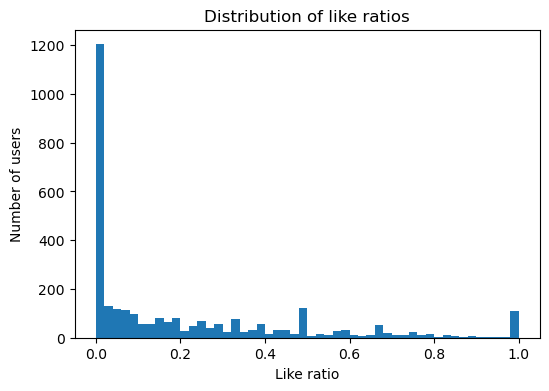

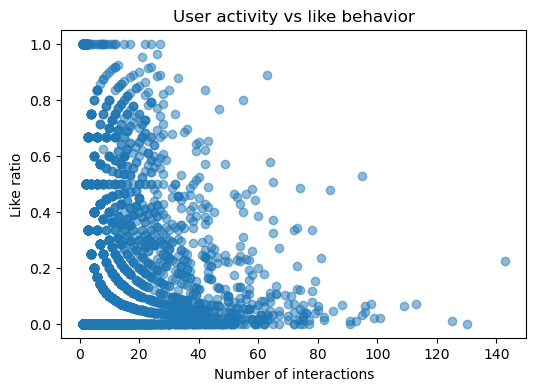

In [41]:
import numpy as np
import matplotlib.pyplot as plt

likes = np.sum(train_data == 1, axis=1)
interactions = np.sum(~np.isnan(train_data), axis=1)

like_ratio = likes / (interactions + 1e-8) #epsilon so we don't divide by zero 

plt.figure(figsize=(6, 4))
plt.hist(like_ratio, bins=50)
plt.xlabel("Like ratio")
plt.ylabel("Number of users")
plt.title("Distribution of like ratios")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(interactions, like_ratio, alpha=0.5)
plt.xlabel("Number of interactions")
plt.ylabel("Like ratio")
plt.title("User activity vs like behavior")
plt.show()

As illustrated in both graphs, users exhibit high selectivity, evidenced by a dominant like ratio of 0 (representing explicit dislikes, not NaN values). While a minority of users show a like ratio of 1.0 (non-selective) or 0.5 (moderately selective), the overall distribution confirms that the vast majority of the user base is highly restrictive in their interactions.

## WebLab solutions

In [42]:
# Solution: NMF routine (for unit test on weblab)

def nmf(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Decomposes the original sparse matrix X into two matrices W and H. 
    """
    # Initialize W and H with random non-negative values
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    last_error = np.linalg.norm(X - W @ H, 'fro')
    # START ANSWER
    for i in range(max_iter):
        H *= (W.T @ X) / ((W.T @ W @ H) + 1e-9)
        W *= (X @ H.T) / ((W @ H @ H.T) + 1e-9)

        new_error = np.linalg.norm(X - W @ H, 'fro')

        if(abs(last_error - new_error) < tol):
            break

        last_error = new_error


    # END ANSWER

    return W, H

In [43]:
class HashFunction:
    """
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """
        
        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value

# Solution: Min-hashing routine (for unit test on weblab)

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """
    
    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    
    index_map = {v: i for i, v in enumerate(sorted_space)}
    # START ANSWER
    for i, curr_hash in enumerate(hashes):
        for j, curr_set in enumerate(ids):
            minHash = sys.maxsize
            for k, curr_id in enumerate(curr_set):
                hashs = curr_hash.hashf(index_map[curr_id], len(sorted_space))
                if(hashs < minHash):
                    minHash = hashs
            result[i][j] = minHash
    # END ANSWER
    
    return result

## NMF-based recommender system

In [44]:
# Step 1: NMF routine which can handle NaNs! (for the 'real data' NMF recommender system task)

def nmf_nan(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Computes NMF of matrix X which includes 'unknown' NaN values.
    """

    mask = ~np.isnan(X)
    X_filled = np.nan_to_num(X, nan=0.0)

    # Initialize W and H with random non-negative values
    W = np.random.rand(X_filled.shape[0], n_components)
    H = np.random.rand(n_components, X_filled.shape[1])

    # Now fill the NaN values with zeroes so that it don't include in the loss
    diff = X_filled - W @ H
    last_error = np.sqrt(np.sum(diff[mask] ** 2))

    for i in range(max_iter):
        H *= (W.T @ X_filled) / (W.T @ W @ H + 1e-9)
        W *= (X_filled @ H.T) / (W @ H @ H.T + 1e-9)

        # Now fill the NaN values with zeroes so that it don't include in the loss
        diff = X_filled - W @ H
        new_error = np.sqrt(np.sum(diff[mask] ** 2))

        if(abs(last_error - new_error) < tol):
            break

        last_error = new_error
    

    return W, H, last_error

Fitting NMF with n_components = 5
Fitting NMF with n_components = 10
Fitting NMF with n_components = 20
Fitting NMF with n_components = 50
Fitting NMF with n_components = 100


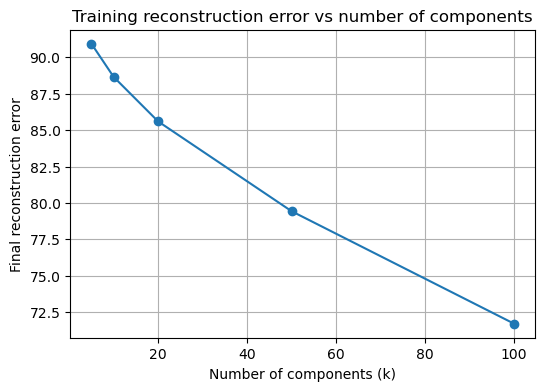

In [45]:
# Step 2: Fit train data

np.random.seed(5)

list_components = np.array([5, 10, 20, 50, 100])
reconstruction_errors = []

for k in list_components:
    print(f"Fitting NMF with n_components = {k}")

    W, H, err = nmf_nan(
        train_data,
        n_components=k,
        max_iter=100, # putting 100 so we don't blow our pcs up
        tol=1e-3
    )

    reconstruction_errors.append(err)

plt.figure(figsize=(6,4))
plt.plot(list_components, reconstruction_errors, marker='o')
plt.xlabel("Number of components (k)")
plt.ylabel("Final reconstruction error")
plt.title("Training reconstruction error vs number of components")
plt.grid(True)
plt.show()

Training accuracy for n_components = 5
Training accuracy for n_components = 10
Training accuracy for n_components = 20
Training accuracy for n_components = 50
Training accuracy for n_components = 100


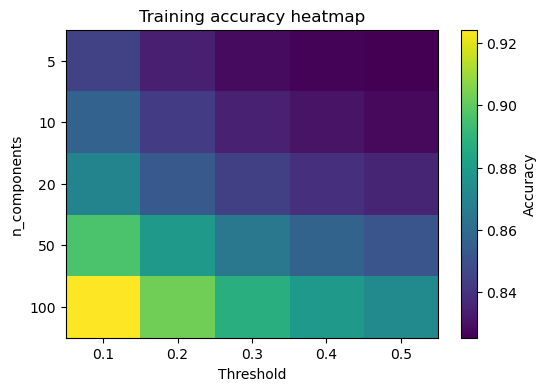

In [46]:
# Step 3: Get training accuracies

# Declare some list of thresholds to try: list_thr...
list_thr = [0.1, 0.2, 0.3, 0.4, 0.5]
train_accuracies = np.zeros((len(list_components), len(list_thr)))

for c, k in enumerate(list_components):
    print(f"Training accuracy for n_components = {k}")

    W, H, _ = nmf_nan(
        train_data,
        n_components=k,
        max_iter=100,
        tol=1e-3
    )

    X_hat = W @ H
    mask = ~np.isnan(train_data)

    for t, thr in enumerate(list_thr):
        X_pred = (X_hat >= thr).astype(int)

        correct = (X_pred[mask] == train_data[mask]).sum()
        total = mask.sum()

        train_accuracies[c, t] = correct / total

plt.figure(figsize=(6,4))

plt.imshow(train_accuracies, cmap='viridis', aspect='auto')

plt.xticks(range(len(list_thr)), list_thr)
plt.yticks(range(len(list_components)), list_components)

plt.xlabel("Threshold")
plt.ylabel("n_components")
plt.title("Training accuracy heatmap")
plt.colorbar(label="Accuracy")

plt.show()

Validation accuracy for n_components = 5
Validation accuracy for n_components = 10
Validation accuracy for n_components = 20
Validation accuracy for n_components = 50
Validation accuracy for n_components = 100


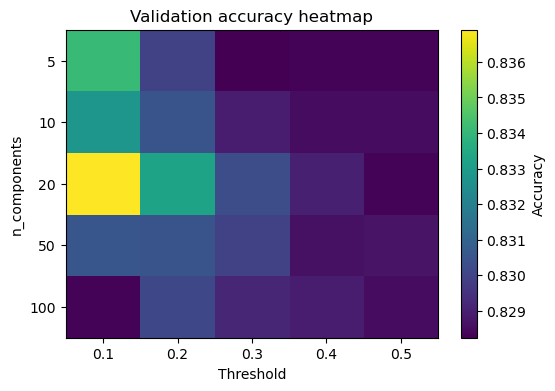

Best k to choose: 20 Best threshold to choose: 0.1


In [47]:
# Step 4: Get validation accuracies
# This is where we fit the n_components and the threshold

val_accuracies = np.zeros((len(list_components), len(list_thr)))

for c, k in enumerate(list_components):
    print(f"Validation accuracy for n_components = {k}")

    # Fit ONLY on training data
    W, H, _ = nmf_nan(
        train_data,
        n_components=k,
        max_iter=100,
        tol=1e-3
    )

    X_hat = W @ H
    mask_val = ~np.isnan(val_data)

    for t, thr in enumerate(list_thr):
        X_pred = (X_hat >= thr).astype(int)

        correct = (X_pred[mask_val] == val_data[mask_val]).sum()
        total = mask_val.sum()

        val_accuracies[c, t] = correct / total

plt.figure(figsize=(6,4))
plt.imshow(val_accuracies, cmap='viridis', aspect='auto')

plt.xticks(range(len(list_thr)), list_thr)
plt.yticks(range(len(list_components)), list_components)

plt.xlabel("Threshold")
plt.ylabel("n_components")
plt.title("Validation accuracy heatmap")
plt.colorbar(label="Accuracy")
plt.show()

best_idx = np.unravel_index(np.argmax(val_accuracies), val_accuracies.shape)

best_k = list_components[best_idx[0]]
best_thr = list_thr[best_idx[1]]

print("Best k to choose:", best_k,  "Best threshold to choose:", best_thr)


In [48]:
# Step 5: Get the final test accuracy
# We use the n_components and the threshold we fit on the validation set

# Fit model with chosen parameters on TRAINING data
W, H, _ = nmf_nan(
    train_data,
    n_components=best_k,
    max_iter=100,
    tol=1e-3
)

# Reconstruction
X_hat = W @ H

# Threshold using chosen threshold
X_pred = (X_hat >= best_thr).astype(int)

# Only evaluate on observed test entries
mask_test = ~np.isnan(test_data)

correct = (X_pred[mask_test] == test_data[mask_test]).sum()
total = mask_test.sum()

test_accuracy = correct / total

print(f"Test accuracy: {test_accuracy*100:.2f}%, threshold: {best_thr}, n_components: {best_k}")

Test accuracy: 83.45%, threshold: 0.1, n_components: 20


## Distance-based recommender system

In [49]:
# Use min-hashing on the rows and find the nearest neighbors using Jaccard distance

# Use min-hashing on the columns and find the nearest neighbors using Jaccard distance

In [50]:
# Aggregate the user-user and item-item nearest neighbor information to estimate recommendations



In [51]:
# Cross-validate on the validation data: number of hash functions and number of neighbors
# (As we did for NMF above, for the n_components and the threshold.)

In [52]:
# Report recommendation accuracy on the independent test data